In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.rcParams['figure.figsize'] = [12,8]

from collections import defaultdict

In [2]:
from IPython.core.display import HTML
css = open('Style/style-table.css').read() + open('Style/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

# Data loading / preparation

Loading the **main dataset** and making some cleaning in some features.

dataset source official link: [click here](https://data.edmonton.ca/Community-Centres/Most-Popular-Books-by-Branch-Edmonton-Public-Libra/qdgm-hex6)

> The dataset used here was the original dataset with genre information imported using Google Books API. If you would like to see how it was done, please check the repository on [Github](https://github.com/FernandoMeiraFilho/Edmonton-Library-EDA)

In [3]:
root_data = pd.read_csv('ImportingNewData/Final_Dataset.csv').iloc[:,13:]
root_data.head()

,row_id,branch_id,branch_name,holds,title,author,date,url,genre,google_rating,publishing_Date
0,EPLLON20150316The girl on the train / Paula Ha...,EPLLON,Londonderry Branch,36,The girl on the train,Hawkins Paula,03/16/2015 12:00:00 AM,http://epl.bibliocommons.com/search?t=smart&q=...,Fiction,3.5,2015.0
1,EPLLON20150316The maze runner / James Dashner,EPLLON,Londonderry Branch,18,The maze runner,Dashner James,03/16/2015 12:00:00 AM,http://epl.bibliocommons.com/search?t=smart&q=...,Juvenile Fiction,3.5,2014.0
2,EPLLON20150316Crash & burn : a novel / Lisa Ga...,EPLLON,Londonderry Branch,17,Crash & burn : a novel,Gardner Lisa,03/16/2015 12:00:00 AM,http://epl.bibliocommons.com/search?t=smart&q=...,Young Adult Fiction,4.0,2013.0
3,EPLLON20150316Gray Mountain / John Grisham,EPLLON,Londonderry Branch,14,Gray Mountain,Grisham John,03/16/2015 12:00:00 AM,http://epl.bibliocommons.com/search?t=smart&q=...,Fiction,3.5,2014.0
4,EPLLON20150316Cambridge IELTS ... : examinatio...,EPLLON,Londonderry Branch,14,Cambridge IELTS ... : examination papers from ...,University of Cambridge Local Examinations Syn...,03/16/2015 12:00:00 AM,http://epl.bibliocommons.com/search?t=smart&q=...,Foreign Language Study,NaN,2002.0


Loading an **additional dataset** containing the official branch names, latitudes and longitudes (for further graphs).

dataset source official link: [click here](https://data.edmonton.ca/Community-Centres/Public-Libraries/jn25-zspi)

In [4]:
#getting the addresses of the branches 
branch_info = pd.read_csv('Public_Libraries.csv')
keep_columns = ['Branch ID', 'Branch', 'Address', 'Latitude', 'Longitude']
branch_info = branch_info[keep_columns]

branch_info.sort_values('Branch ID').head()

,Branch ID,Branch,Address,Latitude,Longitude
7,EPLABB,Abbottsfield - Penny McKee,3410 - 118 Avenue,53.570451,-113.391518
20,EPLCAL,Calder,12710 - 131 Avenue NW,53.590515,-113.542369
12,EPLCLV,Clareview,3808 - 139 Avenue,53.601302,-113.401769
14,EPLCPL,Capilano,9915 - 67 Street,53.537896,-113.419927
11,EPLCSD,Castle Downs,"106 Lakeside Landing, 15379 Castle Downs Rd",53.615736,-113.516633


### Overall look on data disponibility

**Additional dataset** (branch informations)

In [5]:
include =['object', 'float', 'int'] 
branch_info.describe(include = include).fillna('-').loc[['count', 'unique'], :]

,Branch ID,Branch,Address,Latitude,Longitude
count,21,21,21,21,21
unique,21,21,21,-,-


Very well rounded and clean, should serve as a model for the number of branches and looking to the main dataset.

**Main dataset**

In [6]:
total_lines = len(root_data)
print('This dataset has {} lines.'.format(total_lines))


def line_highlight_count(s):
    '''
    take a series and scalar and highlight if number of lines is less the total number of lines
    '''
    col = s < total_lines
    return ['background-color: yellow' if v else '' for v in col]

def line_highlight_unique(s):
    '''
    take a series and scalar and highlight if number of branches is more than branch info dataset
    '''
    col = s > 21
    return ['background-color: #ffaaaa' if v else '' for v in col]

include =['object', 'float', 'int'] 
desc = root_data.describe(include = include).fillna(0).loc[['count', 'unique'], :]
desc = desc.style.apply(line_highlight_count, axis=1, subset=pd.IndexSlice['count', :])
desc = desc.apply(line_highlight_unique, axis=1, subset=pd.IndexSlice['unique', ['branch_id', 'branch_name']])
desc

This dataset has 32300 lines.


,row_id,branch_id,branch_name,holds,title,author,date,url,genre,google_rating,publishing_Date
count,32300,32300,32300,32300.000000,32300,32134,32300,32300,32289,23963.000000,32300.000000
unique,32300,22,48,0.000000,3312,2375,165,3414,111,0.000000,0.000000


### Identifying data structure and flaws

#### Missing data

In [7]:
mis = root_data.describe(include = include).fillna(0).loc[['count'], :]
mis.loc['count',:].apply(lambda cel: cel-total_lines if (total_lines-cel)>=0 else 0 )

row_id                0.0
branch_id             0.0
branch_name           0.0
holds                 0.0
title                 0.0
author             -166.0
date                  0.0
url                   0.0
genre               -11.0
google_rating     -8337.0
publishing_Date       0.0
Name: count, dtype: float64

So, the most compromised feature here is **google_rating** with approximately 25% of the total data being of NaN values.

#### Understanding genre labeling and consistency

In [10]:
# Lets now look for similar named genres or weird genre labelings
genres_rf = list(root_data['genre'].fillna('-').unique())

genre_inits = defaultdict(list)
for genre in genres_rf:
    genre_inits[genre[0].upper()].append(genre)

for key in sorted(genre_inits.keys()):
    print('\n {} initials: '.format(key))
    print(sorted(genre_inits[key]))


 - initials: 
['-']

 A initials: 
['Alphabet books', 'Amigurumi', 'Animals', 'Architecture', 'Art', 'Automobile driving']

 B initials: 
['Bears', 'Bibles', 'Bildungsromans', 'Biography & Autobiography', 'Biology', 'Board books', 'Body, Mind & Spirit', 'Brothers and sisters', 'Business & Economics', 'Business ethics']

 C initials: 
['Canada', 'Cats', 'Children of divorced parents', "Children's songs", "Children's stories", 'Comic books, strips, etc', 'Comics & Graphic Novels', 'Community life', 'Computer adventure games', 'Computers', 'Conduct of life', 'Control (Psychology)', 'Cooking', 'Cooking, American', 'Crafts & Hobbies', 'Curiosities and wonders']

 D initials: 
['Design', 'Diaries', 'Diary of a wimpy kid (Motion picture)', 'Diesel fuels', 'Drama', 'Drugs']

 E initials: 
['Education', 'Education, Secondary', 'Educational tests and measurements', 'Electric apparatus and appliances', 'Electronic books', 'Elephants', 'Encyclopedias and dictionaries', 'English language', 'Englis

In [15]:
# Bildungsromans genre? what is that?

bildun = root_data[root_data.genre == 'Bildungsromans']
bildun.title.unique()

array(['Paper towns'], dtype=object)

Paper towns is a John Greene Young Adult Fiction book, mislabeled as this strange name, so we will need to fix it.

Although this could be very personal based, there seems some cases where we can intervene:

**Weird labeling:**
- Bildungsromans : as Young Adult Fiction

**Similar labeling:**
- Business & Economics and Business ethics : as Business
- Children of divorced parents , Children's songs , Children's stories : as Children
- 'Cooking', 'Cooking, American': as Cooking
- 'Education', 'Education, Secondary', 'Educational tests and measurements' : as Education
- 'Games', 'Games & Activities', 'Go (Game)' : as Games
- 'Literary Criticism' , 'LITERARY CRITICISM' : as  Literary Criticism
- Self-actualization (Psychology) in women', 'Control (Psychology)' , 'Psychology': as Psychology
- 'Study Aids', 'Medical' : as Medical

In [17]:
# fixing some labels that are similar or weird
genre_fix = {
    'Bildungsromans' : 'Young Adult Fiction',
    'Business & Economics' : 'Business',
    'Business ethics' : 'Business',
    'Children of divorced parents' : 'Children',
    "Children's songs" : 'Children',
    "Children's stories" : 'Children',
    'Cooking, American' : 'Cooking',
    'Education, Secondary' : 'Education', 
    'Educational tests and measurements': 'Education',
    'Games & Activities': 'Games', 
    'Go (Game)' : 'Games',
    'LITERARY CRITICISM' : 'Literary Criticism',
    'Self-actualization (Psychology) in women' : 'Psychology',
    'Control (Psychology)' : 'Psychology',
    'Study Aids' : 'Medical'
    }

# creating a fixed genre column
root_data['genre_fixed'] = root_data['genre'].apply(
                                        lambda genre: genre_fix[genre] if genre in genre_fix.keys() else genre)

root_data[root_data.genre == 'Bildungsromans'].head()

,row_id,branch_id,branch_name,holds,title,author,date,url,genre,google_rating,publishing_Date,genre_fixed
8,EPLLON20150316Paper towns / by John Green,EPLLON,Londonderry Branch,10,Paper towns,Green John,03/16/2015 12:00:00 AM,http://epl.bibliocommons.com/search?t=smart&q=...,Bildungsromans,4.0,2012.0,Young Adult Fiction
200,EPLLON20150309Paper towns / by John Green,EPLLON,Londonderry Branch,12,Paper towns,Green John,03/09/2015 12:00:00 AM,http://epl.bibliocommons.com/search?t=smart&q=...,Bildungsromans,4.0,2012.0,Young Adult Fiction
472,EPLLON20150302Paper towns / by John Green,EPLLON,Londonderry Branch,13,Paper towns,Green John,03/02/2015 12:00:00 AM,http://epl.bibliocommons.com/search?t=smart&q=...,Bildungsromans,4.0,2012.0,Young Adult Fiction
870,EPLLON20150209Paper towns / by John Green,EPLLON,Londonderry Branch,13,Paper towns,Green John,02/09/2015 12:00:00 AM,http://epl.bibliocommons.com/search?t=smart&q=...,Bildungsromans,4.0,2012.0,Young Adult Fiction
1117,EPLLON20150202Paper towns / by John Green,EPLLON,Londonderry Branch,14,Paper towns,Green John,02/02/2015 12:00:00 AM,http://epl.bibliocommons.com/search?t=smart&q=...,Bildungsromans,4.0,2012.0,Young Adult Fiction


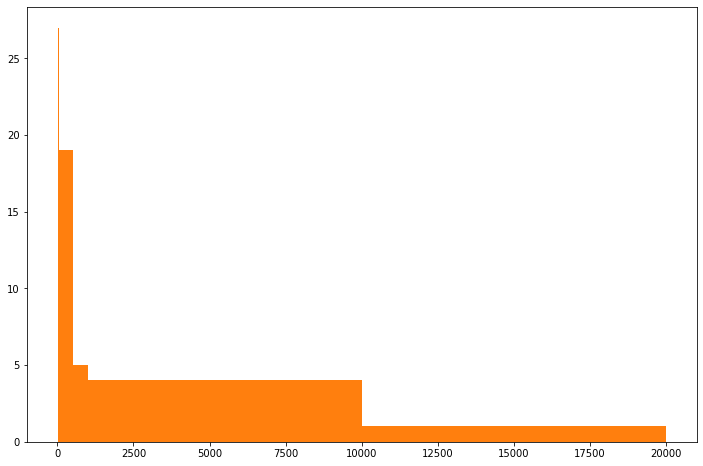

In [37]:
#Understanding the distribution of the genre apearances

genr = root_data[['genre_fixed']]
genr_g = genr.groupby('genre_fixed').agg(genre_occur=('genre_fixed','size'))
genr_g

bins=[1,5,10,50,500,1000,10000,20000]

count, bins, bar = plt.hist(genr_g.genre_occur, bins=bins)
genre_hist = plt.hist(genr_g.genre_occur, bins=bins)

A lot of genres with less than 5 appearances, this could be a fact of very specific genre selection or some problem with the genre brought by the API.

To avoid data pollution, we are going these cases as **'Misc'** genre


In [35]:
# gathering the genres with 1 occurance
few_occur = genr_g.reset_index()
five_less_genres = few_occur[few_occur['genre_occur'] <= 5].genre_fixed.tolist()

#creating refined column for genre
root_data['genre_fixed'] = root_data['genre_fixed'].apply(lambda g: 'Misc' if g in five_less_genres else g)

gencheck = root_data[['genre_fixed']]
gencheck = gencheck.groupby('genre_fixed').agg(genre_occur=('genre_fixed', 'size'))
print('Top 10 genre in appearances')
gencheck.sort_values('genre_occur', ascending=False).head(10)

Top 10 genre in appearances


,genre_occur
genre_fixed,
Fiction,17390
Biography & Autobiography,2304
Juvenile Fiction,2043
House & Home,1253
Cooking,1129
Young Adult Fiction,950
Self-Help,834
Foreign Language Study,696
Business,566


In [36]:
print('Bottom 10 genre in appearances')
gencheck.sort_values('genre_occur', ascending=False).tail(10)

Bottom 10 genre in appearances


,genre_occur
genre_fixed,
Language Arts & Disciplines,11
Photography,11
Games,10
Biology,9
Drugs,8
Language arts (Secondary),7
Board books,7
Munich (Germany),6
Holy Spirit,6


We are still skewed for fiction, but at least our bottom is not populated with a lot of very specific genres with very small appearance numbers.

#### Overwall Look into Publishing Date feature

In [40]:
pub = root_data[['publishing_Date']]
pub_g = pub.groupby(['publishing_Date']).size()
pub_g

publishing_Date
17.0         1
1746.0       1
1852.0       1
1857.0       2
1887.0       1
1891.0       5
1956.0       2
1959.0       1
1961.0       1
1962.0       1
1963.0       1
1965.0       5
1967.0       5
1968.0      13
1969.0       2
1973.0       3
1975.0       9
1977.0       1
1979.0       1
1982.0       2
1983.0       1
1984.0       1
1985.0      22
1986.0       3
1987.0       1
1989.0       1
1991.0       1
1992.0       3
1993.0      32
1996.0      19
1997.0      35
1998.0      12
1999.0      46
2000.0      65
2001.0     139
2002.0     721
2003.0      87
2004.0     249
2005.0      93
2006.0      70
2007.0     152
2008.0     199
2009.0     338
2010.0     490
2011.0     620
2012.0     593
2013.0    1007
2014.0    3313
2015.0    5530
2016.0    6935
2017.0    5464
2018.0    4256
2019.0    1627
2020.0     117
dtype: int64

We have a 17 year value, lets check and see if it needs a fix.

In [41]:
root_data[root_data.publishing_Date==17]

,row_id,branch_id,branch_name,holds,title,author,date,url,genre,google_rating,publishing_Date,genre_fixed
22122,EPLHIG20171030Whipped / by William Deverell,EPLHIG,Highlands,24,Whipped,Deverell William,10/30/2017 12:00:00 AM,http://epl.bibliocommons.com/search?t=smart&q=...,Fiction,2.0,17.0,Fiction


Ok, seems is an error of year format. Whipped by Deverell William is a book published in 2017. Let's just make a manual fix

In [45]:
root_data.loc[22122,'publishing_Date'] = 2017
root_data.loc[22122,'publishing_Date']

2017.0

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 6.000e+00,
        0.000e+00, 1.100e+01, 6.900e+01, 3.221e+04]),
 array([1746. , 1773.4, 1800.8, 1828.2, 1855.6, 1883. , 1910.4, 1937.8,
        1965.2, 1992.6, 2020. ]),
 <a list of 10 Patch objects>)

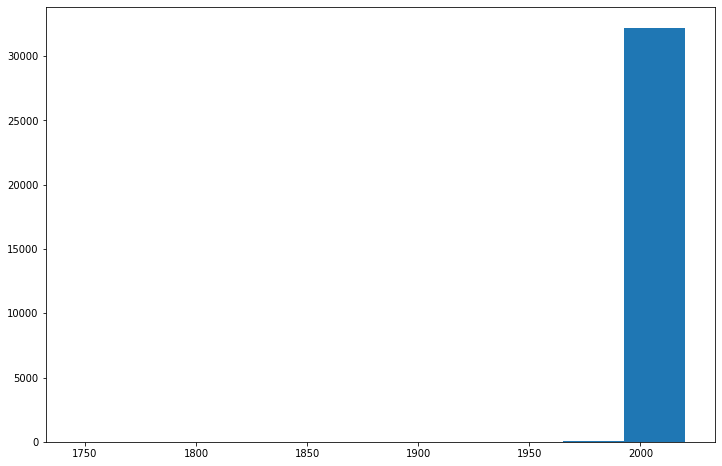

In [47]:
# lets just plot a hist for publishing_Date

plt.hist(root_data.publishing_Date)

#### Branch number inconsistent with additional dataset

Also, it seems that we have a **dislignment concerning the number of branches ids and names (red highlight) with the additional dataset**. 

Let's investigate and fix it.

In [48]:
binfo = branch_info[['Branch ID', 'Branch']].drop_duplicates()
main_binfo = root_data[['branch_id', 'branch_name']].drop_duplicates(subset='branch_id')


merged_binfo = main_binfo.merge(binfo, how='outer', left_on='branch_id', right_on='Branch ID')

#merged_binfo.groupby(['branch_id', 'Branch ID', 'Branch']).size()
merged_binfo.style.highlight_null(null_color='red')

,branch_id,branch_name,Branch ID,Branch
0,EPLLON,Londonderry Branch,EPLLON,Londonderry
1,EPLMNA,Stanley A. Milner Library (Downtown),nan,nan
2,EPLMEA,Meadows Branch,EPLMEA,Meadows
3,EPLABB,Abbottsfield - Penny McKee Branch,EPLABB,Abbottsfield - Penny McKee
4,EPLCAL,Calder Branch,EPLCAL,Calder
5,EPLLHL,Lois Hole Library,EPLLHL,Lois Hole (Callingwood)
6,EPLMLW,Mill Woods Branch,EPLMLW,Mill Woods
7,EPLRIV,Riverbend Branch,EPLRIV,Riverbend
8,EPLSPW,Sprucewood Branch,EPLSPW,Sprucewood
9,EPLCSD,Castle Downs Branch,EPLCSD,Castle Downs


So, once that for us the most important is the data that comes from the main dataset, we have two branches (EPLMNA and EPLGMU) that we will not be able to gather information from the additional dataset, **so we will have to gather the location info manually here**.

** After some research, I found out that the Stanley A. Milner Library now is represented by the Enterprise Square (Downtown) name and ID, so we will just replace the names for this one


**Fixing the branch_info dataset, including the missing branch**

In [49]:
#added the MacEwan unit to the branch info dataset
branch_info = branch_info.append({'Branch ID':'EPLGMU', 'Latitude':53.547389, 'Longitude':113.505425}, ignore_index=True)

branch_info.tail()

,Branch ID,Branch,Address,Latitude,Longitude
17,EPLWMC,Whitemud Crossing,"145 Whitemud Crossing Shopping Centre, 4211 - ...",53.479486,-113.504122
18,EPLHVY,Heritage Valley,2755-119A Street SW,53.407480,-113.537569
19,EPLMLW,Mill Woods,2610 Hewes Way,53.455445,-113.434380
20,EPLCAL,Calder,12710 - 131 Avenue NW,53.590515,-113.542369
21,EPLGMU,NaN,NaN,53.547389,113.505425


**Fixing the root_data dataset, changing the name for the EPLMNA and normalizing branch names**

In [50]:
branch_normalizer = {row['branch_id']:row['branch_name'] for index,row in merged_binfo.iterrows()}
branch_normalizer
    

{'EPLLON': 'Londonderry Branch',
 'EPLMNA': 'Stanley A. Milner Library (Downtown)',
 'EPLMEA': 'Meadows Branch',
 'EPLABB': 'Abbottsfield - Penny McKee Branch',
 'EPLCAL': 'Calder Branch',
 'EPLLHL': 'Lois Hole Library',
 'EPLMLW': 'Mill Woods Branch',
 'EPLRIV': 'Riverbend Branch',
 'EPLSPW': 'Sprucewood Branch',
 'EPLCSD': 'Castle Downs Branch',
 'EPLCPL': 'Capilano Branch',
 'EPLWOO': 'Woodcroft Branch',
 'EPLHIG': 'Highlands Branch',
 'EPLSTR': 'Strathcona Branch',
 'EPLWMC': 'Whitemud Crossing Branch',
 'EPLGMU': 'MacEwan University',
 'EPLCLV': 'Clareview Branch',
 'EPLJPL': 'Jasper Place Branch',
 'EPLIDY': 'Idylwylde Branch',
 'EPLMCN': 'McConachie Branch',
 'EPLWHP': 'West Henday Promenad (Lewis Estates) Branch',
 'EPLHVY': 'Heritage Valley',
 nan: nan}

In [51]:
# changing the name and code for the Stanley A. Milner Library and normaling
branch_normalizer = {row['branch_id']:row['branch_name'] for index,row in merged_binfo.iterrows()}
branch_normalizer['EPLESQ'] = 'Enterprise Square (Downtown)'

root_data['branch_id'] = root_data['branch_id'].apply(lambda x: 'EPLESQ' if x == 'EPLMNA' else x)
root_data['branch_name'] = root_data['branch_id'].apply(lambda x: branch_normalizer[x] )

root_data.groupby(['branch_id', 'branch_name']).size()

branch_id  branch_name                                
EPLABB     Abbottsfield - Penny McKee Branch              1649
EPLCAL     Calder Branch                                  1649
EPLCLV     Clareview Branch                               1640
EPLCPL     Capilano Branch                                1645
EPLCSD     Castle Downs Branch                            1648
EPLESQ     Enterprise Square (Downtown)                   1650
EPLGMU     MacEwan University                             1060
EPLHIG     Highlands Branch                               1639
EPLHVY     Heritage Valley                                 274
EPLIDY     Idylwylde Branch                               1640
EPLJPL     Jasper Place Branch                            1640
EPLLHL     Lois Hole Library                              1650
EPLLON     Londonderry Branch                             1650
EPLMCN     McConachie Branch                               680
EPLMEA     Meadows Branch                                 1649


## Saving the cleaned data frames for analysis

#### Branch info

In [55]:
branch_info.to_csv('branch_info.csv', index=False)

#### Main data

In [56]:
root_data.to_csv('library_ranks_prepared.csv', index=False)